## TODOS:
* Conditional Training
* Template matching
* ~~Try label smoothing on each sample rather than a preprocessing step~~
    * Worse 
* Determine the best way to handle null (empty) labels
    * Appears to be constant 0
* Label propagation by patient-study
* AP/PA/Lateral ensemble (weight based on)
* figure out if train can be split into new val set ()


## Cautions:
* ~~Currently setting No Findings = 1 if all others are nan or 0. Could be dangerous to do so, but will make AUC calculations easier~~
    * Preliminary findings suggest this should not be done.

## Useful discoveries
* There are 0 items that have `No Finding` = 1 and any of the disease categories in {-1,1}. There are `Support Devices`  = 1, however. 
* There are 28,480 that have 0's in all disease categories. Of those, 6099 have 0 in `No Finding` category. Of those, 4256 also have 0 in `Support Devices`
* Validation: 9 items all label=0, 39 items all-`Support Devices`=0, 77 items all-{`No Finding`,`Support Devices`}=0)
* 138,358 items in the training set do not contain a -1, 85,056 contain at least one -1
* 21 training samples contain 6 -1s

#### Imports

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import random
from pathlib import Path
from collections import OrderedDict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import models
import torchvision.transforms as T

#from efficientnet_pytorch import EfficientNet
#from torchvision.utils import make_grid

#import torchsummary
# local files
# from plotting import show_batch, plot_learning_curves
# from modeling import CheXModel
from dataaug import TemplateCrop

In [16]:
%run ../modeling.py
%run ../plotting.py
#%run ../dataaug.py

In [19]:
h1 = pickle.load(open('../save/histories/dn121_thawsteplr256bSig_223k.pkl','rb'))

In [60]:
h2 = pickle.load(open('../save/histories/dn121_ct_allcls.pkl','rb'))

#### Globals

In [4]:
USE_CUDA = False#True
ON_AWS = False#True
NUM_WORKERS = 4 if ON_AWS else 0 
DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [5]:
SEED = 404
def seed_everything(seed=SEED, env=None):
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
TARGET_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other',
       'Fracture', 'Support_Devices']


## Data

In [7]:
PATH_DATA = Path('../data/')
chxpath = PATH_DATA/'CheXpert-v1.0-small/'
path_train = chxpath/'train'
path_valid = chxpath/'valid'

In [8]:
df_train = pd.read_csv(chxpath/'train.csv')
df_valid = pd.read_csv(chxpath/'valid.csv')

In [9]:
def label_smooth(df, method='uones', smooth_bounds=None):
    df_sub = df.copy()
    if smooth_bounds is None:
        eps = 1e-5
        if method == 'uones':
            smooth_bounds = (0.55, 0.85+eps)
        elif method=='uzeros':
            smooth_bounds = (0, 0.30+eps)
        else:
            smooth_bounds = (0, 0.85+eps)
    
    if method in ['uones','uzeros']:
        smooth_distrb = np.random.uniform(*smooth_bounds,df_sub[TARGET_LABELS].shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_sub[TARGET_LABELS]==-1, smooth_distrb, df_sub[TARGET_LABELS])
        
    return df_sub

def proc_df(df, method='uones', smooth=True, nafill_val=0, ufill_val=1, **kwargs):
    """
    Preprocess dataframe for model consumption
    
    Args:
        df (pandas.DataFrame): dataframe containing img paths, metadata, and labels.
        method (str), ('uzeros','uones','constant'): method for replacing uncertainty labels (default: 'uones')
        smooth (bool): use Label Smoothing Regression (LSR) only applies when `method`=('uzeros','uones') (default: True) 
        nafill_val (int,float): value used to fill nan values (default: 0)
        ufill_val (int,float): value used to fill -1 (uncertainty) labels
    
    kwargs:
        smooth_bounds (tuple(float,float)): replace -1 labels uniform random values between the given bounds
        (default: `method`='uzeros': (0,0.3001), `method`='uones': (0.55,0.8501) when `Smooth`=True, 
                
    Returns:
        processed_df: pandas.Dataframe
    """
    
    is_val = df['Path'].str.contains('valid').all()
    df_sub = df.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    
    if is_val:
        return df_sub # val set has no nans, no -1s
    
    df_targets = df_sub[TARGET_LABELS]
    
    if isinstance(nafill_val,tuple):
        nan_smooth_distrb = np.random.uniform(*nafill_val, df_targets.shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_targets.isna(), nan_smooth_distrb, df_targets)
    else:
        df_sub = df_sub.fillna(nafill_val)
    
    if smooth:
        df_sub = label_smooth(df_sub, method, kwargs.get('smooth_bounds'))
    elif method == 'constant':
        df_sub = df_sub.replace(-1,ufill_val)
    elif method in ['uzeros','uones'] and ufill_val not in [0.0,1.0]:
        print(f'WARNING: Overwritting `ufill_val` to match method "{method}"')
        ufill_val = 1.0 if method=='uones' else 0.0
        df_sub = df_sub.replace(-1,ufill_val)
    
    df_sub.loc[:,TARGET_LABELS] = df_sub.loc[:,TARGET_LABELS].astype(float)
    
    return df_sub

In [10]:
PATH_PART = Path('../partion_sample/partition_data')
TARGET5_LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
TARGET5_IDX = [TARGET_LABELS.index(t) for t in TARGET5_LABELS]

In [11]:
df_master = pd.read_csv(PATH_PART/'CheX_Full_02.csv')
df_sampb2 = pd.read_csv(PATH_PART/'CheX_Sample_B2.csv')

In [12]:
def make_df_merged(df_master):
    # Filter out undesirable data entries
    data_tot = df_master[(df_master.Dataset_ID ==1) 
                         & (df_master.gender != 'U') 
                         & df_master.ap_pa_ll.isin(['AP','LL','PA']) 
                         & df_master[TARGET_LABELS].notna().any(axis=1)].reset_index(drop=True)

    # Count each quanity of nan, -1, 0, and 1 labels per sample
    count_mat = np.vstack((np.isnan(data_tot[TARGET_LABELS].values).sum(1),
                           (data_tot[TARGET_LABELS].values == -1).sum(1),
                           (data_tot[TARGET_LABELS].values == 0).sum(1),
                           (data_tot[TARGET_LABELS].values == 1).sum(1))).T

    # Create an equal-index dataframe
    df_counts = pd.DataFrame(count_mat,index=data_tot.index, columns=['n_nan','n_unk','n_neg','n_pos'])
    df_totcnts = pd.concat([data_tot[['patient_id','study','CheX_Image_ID']],df_counts],axis=1)
    
    # Assign patient-study group id (Option 1 BROKEN)
    #psid = df_totcnts['patient_id'].astype(str).str.pad(7,'right','0').str.cat(df_totcnts['study'].astype(str)).astype(int)
    psid = df_totcnts.groupby(['patient_id','study']).ngroup() # (Option 2)
    df_totcnts.insert(2,'psid',psid)
    
    df_merged_all = data_tot.merge(df_totcnts)
    
    return df_merged_all

In [15]:
dropcols = ['Dataset_ID','gender','study','view_num','age_num']#'patient_id'
df_merge = make_df_merged(df_master).drop(columns=dropcols)

In [16]:
df_merge = df_merge[['CheX_Image_ID','ap_pa_ll','psid','patient_id','File_Path','n_nan','n_unk','n_neg','n_pos']+TARGET_LABELS]

In [ ]:
def modal_plabs(df_train,out_path='../save/modal_patient_labels.csv'):
    df_ptrain = df_train.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    df_ptrain['patient_id'] = df_ptrain.Path.str.extract(r'patient(\d+)').astype(int)
    plab_prop = df_ptrain.groupby('patient_id')[TARGET_LABELS].agg(lambda x: np.nan if x.isna().all() else x.value_counts(dropna=True).idxmax())
    plab_prop.to_csv(out_path)

In [12]:
df_xtrain = df_train.rename(lambda x: x.replace(' ','_'), axis=1)
df_xtrain['patient_id'] = df_xtrain.Path.str.extract(r'patient(\d+)').astype(int)

In [220]:
df_xtrain[df_xtrain['Frontal/Lateral'] == 'Lateral']['AP/PA'].isna().all()

True

In [13]:
df_pxtrain = proc_df(df_xtrain)

### Loss Func experiments

In [50]:
a = torch.rand(32,14)
b = torch.rand(32,128)
c = torch.rand(32,3,244,244)
act = nn.Sigmoid()

lin = nn.Linear(1024,14)

In [51]:
yx = torch.as_tensor(df_pxtrain.iloc[:32,1:-1].values)

In [54]:
m1 = models.densenet121(True)
m1.classifier = lin
load_trained(m1,'densenet121_65k.pt','','../save/models/')#.classifier = lin
c1 = nn.BCEWithLogitsLoss()
for p in filter(lambda x: hasattr(x,'weight'), m1.parameters()):
    p.requires_grad_(False)
    
with torch.no_grad():
    o1 = m1(c)
    l1 = c1(o1,yx)

In [55]:
m2 = models.densenet121(True)
m2.classifier = lin
load_trained(m2,'densenet121_65k.pt','','../save/models/')#.classifier = lin
c2 = nn.BCELoss()
for p in filter(lambda x: hasattr(x,'weight'), m2.parameters()):
    p.requires_grad_(False)
    
with torch.no_grad():
    o2 = m2(c)
    l2 = c2(torch.sigmoid(o2),yx.float())

In [56]:
o1[:,5] = o1[:,5]*100

In [57]:
o2[:,5] = o2[:,5]*100

In [58]:
c1(o1,yx.float()),c2(torch.sigmoid(o2),yx.float())

(tensor(1.8587), tensor(1.4342))

In [59]:
c1(torch.clamp(o1,-100,100),yx.float())

tensor(1.4342)

In [132]:
compute_auc(o1,yx)

0.7303515431589371

In [133]:
compute_auc(o2,yx)

0.7303515431589371

In [125]:
m2.classifier[0]

Linear(in_features=1024, out_features=14, bias=True)

In [127]:
l1,l2

(tensor(0.4253, dtype=torch.float64), tensor(0.4253))

In [112]:
compute_auc(o2,yx)

0.49361280739395935

In [113]:
compute_auc(o1,yx)

0.49361280739395935

In [108]:
(torch.sigmoid(o1) == o2).all()

tensor(True)

In [80]:
compute_auc(torch.sigmoid(o2),yx)

0.5991747813170489

In [ ]:
targ = target.round().detach().to('cpu')
out = torch.sigmoid(out).detach().to('cpu')
score = roc_auc_score(targ, out, average='micro',multi_class='ovo')

## Misc-EDA

In [243]:
ims = [cv2.imread(str(PATH_DATA/df_xtrain[df_xtrain['patient_id'] == 28746].loc[120078:].iloc[i,0])) for i in range(3)]

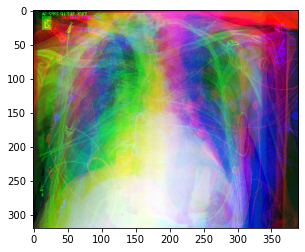

In [248]:
ims = [cv2.imread(str(PATH_DATA/df_xtrain[df_xtrain['patient_id'] == 28746].loc[120078:].iloc[i,0])) for i in range(3)]
plt.imshow(np.dstack(ims))#.shape

In [249]:
pat_ims = df_xtrain.groupby(['patient_id'])['Path'].agg(len).sort_values()#.apply(lambda x: len(x))

patient_id
1         1
43652     1
43647     1
43642     1
43641     1
         ..
34615    85
24163    86
4462     89
33155    92
28746    92
Name: Path, Length: 64540, dtype: int64

In [338]:
pat_lims = df_xtrain[df_xtrain['Frontal/Lateral'] == 'Lateral'].groupby('patient_id')['Path'].count().sort_values()

In [347]:
pat_fims = df_xtrain[df_xtrain['Frontal/Lateral'] == 'Frontal'].groupby('patient_id')['Path'].count().sort_values()

In [348]:
pat_fims

patient_id
1         1
38441     1
38442     1
38444     1
38447     1
         ..
5702     79
34615    85
28746    89
4462     89
33155    91
Name: Path, Length: 64534, dtype: int64

In [290]:
pats3 = pat_ims[pat_ims == 3].index
pats2 = pat_ims[pat_ims == 2].index

In [374]:
def rgb_stack(dfx, patient_id, save_path=None):
    paths = dfx.loc[dfx['patient_id'] == patient_id,'Path'][:3]
    flg = cv2.IMREAD_UNCHANGED if len(paths) > 1 else cv2.IMREAD_COLOR
    imgs = [cv2.resize(cv2.imread(str(PATH_DATA/p),flg),(256,256)) for p in paths]
    if len(imgs) == 2:
        imgs.append(np.mean(tims,0).astype(np.uint8))
    ims = np.dstack(imgs)#.reshape(256,256,3)
    plt.imshow(ims)#.shape
    if save_path is not None:
        plt.imsave(save_path, ims)

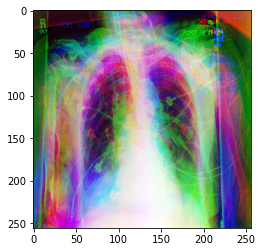

In [370]:
rgb_stack(df_xtrain, patient_id=pat_fims[pat_fims == 3].index[7],save_path='img_expr/front7.png')

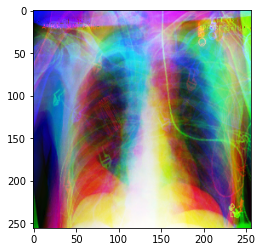

In [371]:
rgb_stack(df_xtrain, patient_id=pat_ims[pat_ims == 3].index[0],save_path='img_expr/front0.png')

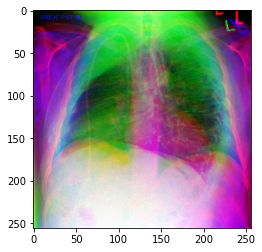

In [331]:
rgb_stack(df_xtrain, patient_id=pat_ims[pat_ims == 4].index[5])

In [ ]:
cv2.imread

In [308]:
tims = [cv2.resize(cv2.imread(str(PATH_DATA/p),cv2.IMREAD_UNCHANGED),(256,256)) for p in df_xtrain.loc[df_xtrain['patient_id']==pats2[0],'Path']]

In [311]:
tims2 = [cv2.resize(cv2.imread(str(PATH_DATA/p),0),(256,256)) for p in df_xtrain.loc[df_xtrain['patient_id']==pats2[0],'Path']]

In [315]:
(tims[1] == tims2[1]).all()

True

In [310]:
tims[0].shape

(256, 256)

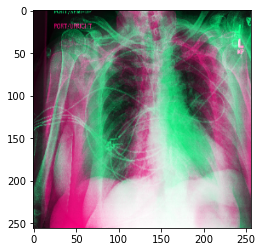

In [376]:
rgb_stack(df_xtrain, patient_id=pats2[0],save_path='img_expr/front2c0.png')

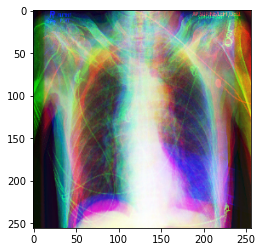

In [372]:
rgb_stack(df_xtrain, patient_id=pats3[1],save_path='img_expr/front1.png')

In [265]:
df_xtrain.loc[df_xtrain['patient_id'] == pats3[2],'Path'][:3]

114415    CheXpert-v1.0-small/train/patient27456/study1/...
114416    CheXpert-v1.0-small/train/patient27456/study2/...
114417    CheXpert-v1.0-small/train/patient27456/study2/...
Name: Path, dtype: object

In [379]:
models.DenseNet??

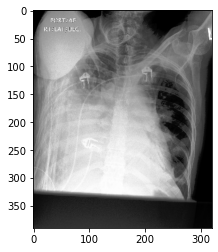

In [228]:
plt.imshow(cv2.imread(str(PATH_DATA/df_xtrain[df_xtrain['AP/PA']=='RL'].iloc[0,0])))

In [208]:
pd.get_dummies(df_xtrain.iloc[:,1:5],columns=['Sex','Frontal/Lateral','AP/PA'])

,Age,Sex_Female,Sex_Male,Sex_Unknown,Frontal/Lateral_Frontal,Frontal/Lateral_Lateral,AP/PA_AP,AP/PA_LL,AP/PA_PA,AP/PA_RL
0,68,1,0,0,1,0,1,0,0,0
1,87,1,0,0,1,0,1,0,0,0
2,83,1,0,0,1,0,1,0,0,0
3,83,1,0,0,0,1,0,0,0,0
4,41,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
223409,59,0,1,0,1,0,1,0,0,0
223410,59,0,1,0,1,0,1,0,0,0
223411,0,1,0,0,1,0,1,0,0,0
223412,0,1,0,0,1,0,1,0,0,0


In [64]:
age_sets = df_xtrain.groupby('patient_id')['Age'].agg(set)#.sort(len)#.value_counts()

In [94]:
import scipy.stats as sps

In [98]:
sps.f_oneway(df_xtrain.loc[df_xtrain.Age>60,TARGET_LABELS].values,df_xtrain.loc[df_xtrain.Age<=60,TARGET_LABELS].values)

F_onewayResult(statistic=array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan]), pvalue=array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan]))

In [185]:
gt60 = df_xtrain.loc[df_xtrain.Age>60,TARGET_LABELS].values#fillna(0).values
le60 = df_xtrain.loc[df_xtrain.Age<=60,TARGET_LABELS].values#fillna(0).values

In [196]:
sps.median_abs_deviation(np.nansum(le60,0),np.nansum(gt60,0))

F_onewayResult(statistic=0.052187229333299064, pvalue=0.8210873447850124)

In [199]:
sps.kendalltau(np.nansum(le60,0),np.nansum(gt60,0))

KendalltauResult(correlation=0.8461538461538461, pvalue=1.5144366582858646e-06)

In [87]:
df_xtrain.groupby('patient_id')['Age'].plot.hist()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002C7115A4730> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:ylabel='Frequency'>

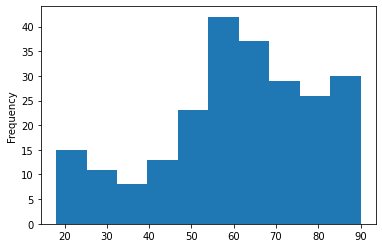

In [78]:
df_valid.Age.plot.hist()

In [73]:
df_xtrain.groupby('patient_id')['Age'].agg(np.ptp).sort_values()

patient_id
1         0
42785     0
42786     0
42787     0
42788     0
         ..
16987    13
21378    13
18365    13
10226    14
48183    14
Name: Age, Length: 64540, dtype: int64

In [70]:
sorted(age_sets,key=len,reverse=True)#.sort_values(key=lambda)

[{18, 19, 21, 22, 23, 26, 27, 28, 29, 30},
 {57, 58, 59, 60, 61, 62, 64, 66, 67, 68},
 {32, 33, 34, 35, 37, 38, 39, 40, 41, 42},
 {22, 23, 24, 26, 27, 28, 29, 30, 31, 32},
 {56, 57, 58, 59, 60, 61, 62, 63, 64, 66},
 {57, 59, 60, 61, 62, 63, 64, 66, 68},
 {36, 37, 38, 39, 41, 42, 43, 46, 47},
 {63, 64, 65, 66, 67, 68, 69, 70, 73},
 {73, 74, 76, 77, 78, 80, 81, 83, 84},
 {45, 46, 47, 48, 49, 52, 53, 54, 55},
 {27, 28, 29, 30, 31, 32, 33, 34, 35},
 {52, 55, 56, 57, 58, 60, 62, 63},
 {64, 65, 66, 67, 68, 71, 72, 73},
 {49, 50, 51, 52, 54, 55, 58, 61},
 {67, 69, 72, 73, 76, 77, 78, 79},
 {23, 24, 26, 29, 30, 31, 32, 34},
 {62, 63, 64, 65, 66, 67, 68, 69},
 {31, 32, 33, 34, 35, 36, 37, 38},
 {60, 61, 62, 63, 66, 68, 69, 70},
 {72, 73, 74, 76, 77, 81, 84, 85},
 {24, 25, 26, 27, 28, 29, 31, 32},
 {45, 46, 47, 48, 49, 54, 55, 56},
 {40, 41, 43, 44, 45, 46, 47, 48},
 {57, 59, 60, 61, 62, 63, 64, 65},
 {53, 54, 55, 56, 57, 58, 59, 60},
 {36, 38, 39, 40, 41, 44, 45, 46},
 {44, 45, 46, 47, 48, 49, 

In [ ]:
df_ptrain = df_train.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])

In [19]:
df_ptrain['patient_id'] = df_ptrain.Path.str.extract(r'patient(\d+)').astype(int)

In [120]:
kstats

KruskalResult(statistic=nan, pvalue=nan)

In [51]:
np.allclose(df_ptrain.groupby('patient_id')[TARGET_LABELS].agg(np.nanmax),
df_ptrain.fillna(-2).groupby('patient_id')[TARGET_LABELS].max().replace(-2,np.nan),equal_nan=True)

True

In [49]:
df_ptrain

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
patient_id,,,,,,,,,,,,,,
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
2,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64536,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0
64537,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,0.0,1.0,NaN,NaN,NaN
64538,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
np.nanmax

In [24]:
df_fplabs = df_ptrain.groupby('patient_id')[TARGET_LABELS].first()

In [23]:
df_plabs = pd.read_csv('../save/modal_patient_labels.csv',index_col=0)

In [35]:
msk1 = (df_plabs.fillna(5)==df_fplabs.fillna(5)).all(1)

In [37]:
df_plabs[~msk1]

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
patient_id,,,,,,,,,,,,,,
7,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,0.0,1.0
11,NaN,0.0,1.0,1.0,NaN,1.0,0.0,NaN,0.0,1.0,1.0,NaN,NaN,1.0
12,NaN,0.0,-1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0
15,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
17,1.0,-1.0,0.0,NaN,NaN,1.0,-1.0,NaN,NaN,-1.0,-1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64462,NaN,1.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0
64491,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0
64509,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [38]:
df_fplabs[~msk1]

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
patient_id,,,,,,,,,,,,,,
7,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,0.0,1.0
11,NaN,0.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,1.0
12,NaN,0.0,-1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,1.0,NaN,NaN,1.0
15,NaN,NaN,NaN,1.0,NaN,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
17,1.0,-1.0,0.0,NaN,NaN,1.0,-1.0,NaN,NaN,0.0,-1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64462,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0
64491,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0
64509,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [31]:
np.equal(df_plabs,df_fplabs)

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
patient_id,,,,,,,,,,,,,,
1,True,False,False,False,False,False,False,False,False,True,False,False,False,True
2,False,False,True,True,False,True,True,False,True,False,True,False,True,False
3,False,False,False,False,False,True,False,False,False,True,False,False,False,False
4,True,True,False,False,False,False,True,False,False,False,True,False,False,False
5,True,False,True,False,False,False,True,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64536,False,False,False,False,False,True,False,False,True,False,True,False,False,True
64537,False,False,False,True,False,False,False,True,True,True,False,False,False,False
64538,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [29]:
df_plabs.compare(df_fplabs,0)

Enlarged_Cardiomediastinum  Cardiomegaly  Lung_Opacity  \
patient_id                                                                 
7          self                          NaN           NaN           NaN   
           other                         NaN           NaN           NaN   
11         self                          NaN           NaN           NaN   
           other                         NaN           NaN           NaN   
12         self                          NaN           NaN           NaN   
...                                      ...           ...           ...   
64509      other                         NaN           NaN           NaN   
64527      self                          NaN          -1.0           NaN   
           other                         NaN           1.0           NaN   
64537      self                          NaN           NaN           NaN   
           other                         NaN           NaN           NaN   

                  Lung_Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
patient_id                                                                    
7          self           NaN    NaN            NaN        NaN          NaN   
           other          NaN    NaN            NaN        NaN          NaN   
11         self           NaN    1.0            NaN        NaN          NaN   
           other          NaN    0.0            NaN        NaN          NaN   
12         self           NaN    NaN            NaN        NaN          NaN   
...                       ...    ...            ...        ...          ...   
64509      other          NaN    NaN            NaN       -1.0          NaN   
64527      self           NaN    NaN            NaN        NaN          NaN   
           other          NaN    NaN            NaN        NaN          NaN   
64537      self           NaN    NaN            NaN        NaN          NaN   
           other          NaN    NaN            NaN        NaN          NaN   

                  Pneumothorax  Pleural_Effusion  Pleural_Other  Fracture  \
patient_id                                                                  
7          self            0.0               NaN            NaN       NaN   
           other           1.0               NaN            NaN       NaN   
11         self            1.0               1.0            NaN       NaN   
           other           0.0               0.0            NaN       NaN   
12         self            NaN               0.0            NaN       NaN   
...                        ...               ...            ...       ...   
64509      other           NaN               NaN            NaN       NaN   
64527      self            NaN               NaN            NaN       NaN   
           other           NaN               NaN            NaN       NaN   
64537      self            NaN              -1.0            NaN       NaN   
           other           NaN               1.0            NaN       NaN   

                  Support_Devices  
patient_id                         
7          self               NaN  
           other              NaN  
11         self               NaN  
           other              NaN  
12         self               NaN  
...                           ...  
64509      other              NaN  
64527      self               NaN  
           other              NaN  
64537      self               NaN  
           other              NaN  

[31776 rows x 13 columns]

In [25]:
df_plabs.equals(df_fplabs)

False

In [62]:
df_merge.groupby('patient_id')[['n_nan','n_unk','n_neg','n_pos']].diff()#

,n_nan,n_unk,n_neg,n_pos
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0
3,-4.0,4.0,0.0,0.0
4,NaN,NaN,NaN,NaN
...,...,...,...,...
223379,NaN,NaN,NaN,NaN
223380,0.0,-1.0,0.0,1.0
223381,NaN,NaN,NaN,NaN
223382,NaN,NaN,NaN,NaN


In [43]:
df_merge.groupby('psid')[['n_nan','n_unk','n_neg','n_pos']].diff()#.agg('diff')

,n_nan,n_unk,n_neg,n_pos
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
223379,NaN,NaN,NaN,NaN
223380,NaN,NaN,NaN,NaN
223381,NaN,NaN,NaN,NaN
223382,NaN,NaN,NaN,NaN


## EDA

,Edema,Atelectasis,Pneumonia
26,0.0,0.000000,0.0
46,0.0,0.000000,0.0
47,0.0,0.000000,0.0
191,0.0,0.000000,0.0
277,0.0,0.000000,0.0
...,...,...,...
223100,0.0,0.000000,0.0
223141,0.0,0.000000,0.0
223186,0.0,0.571704,0.0
223252,0.0,0.610344,0.0


In [19]:
{'root':
 ['No_Finding','Support_Devices','Pneumothorax', 'Pleural_Effusion', 'Pleural_Other','Fracture',
    {'Enlarged_Cardiomediastinum':['Cardiomegaly'],'Lung_Opacity':['Edema','Lung_Lesion','Atelectasis', 
                     {'Consolidation':['Pneumonia']}]}]
}

{'root': ['No_Finding',
  'Support_Devices',
  'Pneumothorax',
  'Pleural_Effusion',
  'Pleural_Other',
  'Fracture',
  {'Enlarged_Cardiomediastinum': ['Cardiomegaly'],
   'Lung_Opacity': ['Edema',
    'Lung_Lesion',
    'Atelectasis',
    {'Consolidation': ['Pneumonia']}]}]}

In [21]:
{'root':['No_Finding','Support_Devices','Pneumothorax','Pleural_Effusion','Pleural_Other','Fracture','Enlarged_Cardiomediastinum','Lung_Opacity'],
'Enlarged_Cardiomediastinum':['Cardiomegaly'],
 'Lung_Opacity':['Edema','Lung_Lesion','Atelectasis','Consolidation'],
 'Consolidation':['Pneumonia']
}

{'root': ['No_Finding',
  'Support_Devices',
  'Pneumothorax',
  'Pleural_Effusion',
  'Pleural_Other',
  'Fracture',
  'Enlarged_Cardiomediastinum',
  'Lung_Opacity'],
 'Enlarged_Cardiomediastinum': ['Cardiomegaly'],
 'Lung_Opacity': ['Edema', 'Lung_Lesion', 'Atelectasis', 'Consolidation'],
 'Consolidation': ['Pneumonia']}

In [27]:
root_cols = ['No_Finding','Support_Devices','Pneumothorax','Pleural_Effusion','Pleural_Other','Fracture','Enlarged_Cardiomediastinum','Lung_Opacity']
df_ptrain[root_cols][(df_ptrain[root_cols] == 1).any(1)]

,No_Finding,Support_Devices,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Enlarged_Cardiomediastinum,Lung_Opacity
0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
5,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...
223407,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
223408,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
223409,NaN,NaN,0.0,1.0,NaN,NaN,NaN,-1.0
223412,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1.0


In [24]:
df_ptrain[df_ptrain['Enlarged_Cardiomediastinum'] == 1][['Cardiomegaly']]

,Cardiomegaly
13,NaN
28,NaN
55,NaN
147,NaN
199,NaN
...,...
223278,NaN
223314,NaN
223322,NaN
223358,NaN


In [23]:
df_ptrain[df_ptrain['Lung_Opacity'] == 1][['Edema', 'Lung_Lesion', 'Atelectasis', 'Consolidation']]

,Edema,Lung_Lesion,Atelectasis,Consolidation
1,-1.0,NaN,-1.0,-1.0
2,NaN,NaN,NaN,-1.0
3,NaN,NaN,NaN,-1.0
12,NaN,NaN,1.0,NaN
13,NaN,NaN,1.0,NaN
...,...,...,...,...
223399,NaN,NaN,NaN,NaN
223401,NaN,1.0,-1.0,NaN
223405,NaN,NaN,-1.0,NaN
223406,NaN,NaN,-1.0,-1.0


In [31]:
(df_ptrain[['Lung_Opacity','Consolidation']] == 1).all(1)

0         False
1         False
2         False
3         False
4         False
          ...  
223409    False
223410    False
223411    False
223412    False
223413    False
Length: 223414, dtype: bool

In [33]:
df_ptrain[(df_ptrain[['Lung_Opacity','Consolidation']] == 1).all(1)][['Edema','Atelectasis','Pneumonia']]

,Edema,Atelectasis,Pneumonia
26,NaN,NaN,NaN
46,NaN,NaN,NaN
47,NaN,NaN,NaN
191,NaN,NaN,NaN
277,NaN,NaN,NaN
...,...,...,...
223100,NaN,NaN,NaN
223141,NaN,NaN,NaN
223186,NaN,-1.0,NaN
223252,NaN,-1.0,NaN


In [ ]:
['No_Finding','Support_Devices','Pneumothorax', 'Pleural_Effusion', 'Pleural_Other','Fracture',]
['Enlarged_Cardiomediastinum']['Lung_Opacity']
['Cardiomegaly'],['Edema', 'Consolidation','Lung_Lesion','Atelectasis']
['Pneumonia']
hierarchy = {}


In [18]:
df_ptrain[df_ptrain['Lung_Opacity'] == 1]

,Path,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
1,CheXpert-v1.0-small/train/patient00002/study2/...,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
12,CheXpert-v1.0-small/train/patient00007/study1/...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,0.0,1.0
13,CheXpert-v1.0-small/train/patient00007/study2/...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223399,CheXpert-v1.0-small/train/patient64529/study1/...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
223401,CheXpert-v1.0-small/train/patient64531/study1/...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,1.0,NaN,NaN,1.0
223405,CheXpert-v1.0-small/train/patient64534/study1/...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,0.0,0.0,NaN,NaN,NaN
223406,CheXpert-v1.0-small/train/patient64535/study1/...,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN


In [56]:
import scipy.stats as sps
import scipy.spatial.distance as spd

In [57]:
from sklearn.manifold import TSNE

In [63]:
def crop_nd(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(lambda x,y:x+y, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [82]:
tn = 100
tmpimgs = np.stack([crop_nd(cv2.resize(cv2.imread(str(PATH_DATA/df_train.iloc[i,0]),0),(256,256)),(244,244))
                    for i in range(tn)]).reshape((tn,-1))

In [83]:
tsne = TSNE()
tsne_tfm = tsne.fit_transform(tmpimgs)

In [91]:
df_train.loc[:100,'Frontal/Lateral']

0      Frontal
1      Frontal
2      Frontal
3      Lateral
4      Frontal
        ...   
96     Frontal
97     Frontal
98     Frontal
99     Frontal
100    Frontal
Name: Frontal/Lateral, Length: 101, dtype: object

In [93]:
df_train.loc[:100,'Frontal/Lateral'].map({'Frontal':'red','Lateral':'blue'})

0       red
1       red
2       red
3      blue
4       red
       ... 
96      red
97      red
98      red
99      red
100     red
Name: Frontal/Lateral, Length: 101, dtype: object

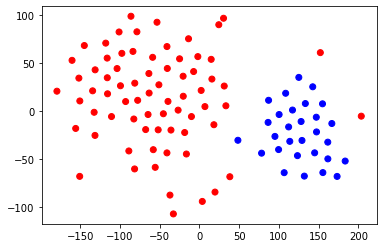

In [95]:
plt.scatter(tsne_tfm[:,0],tsne_tfm[:,1], c=df_train.loc[:99,'Frontal/Lateral'].map({'Frontal':'red','Lateral':'blue'}))

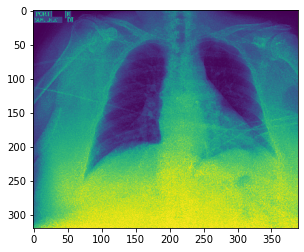

In [65]:
plt.imshow(im1)

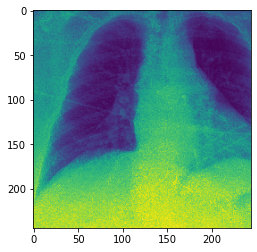

In [66]:
plt.imshow(crop_nd(im1,(244,244)))

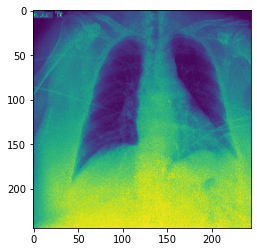

In [70]:
plt.imshow(crop_nd(cv2.resize(im1,(256,256)),(244,244)))

In [64]:
crop_nd(im1,(244,244)).shape

(244, 244)

In [60]:
im1.shape,im2.shape

((320, 389), (320, 390))

In [ ]:
im1

In [ ]:
sps.stats.

In [ ]:
spd.mahalanobis()

In [43]:
df_train.iloc[0,0]

'CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'

In [47]:
im1 = cv2.imread(str(PATH_DATA/df_train.iloc[0,0]),0)

In [48]:
im2 = cv2.imread(str(PATH_DATA/df_train.iloc[1,0]),0)

In [55]:
np.cov(im1.ravel(),im2.ravel())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 124480 and the array at index 1 has size 124800

In [54]:
im1.ravel()

(124480,)

In [50]:
spd.mahalanobis(im1,im2)

TypeError: mahalanobis() missing 1 required positional argument: 'VI'

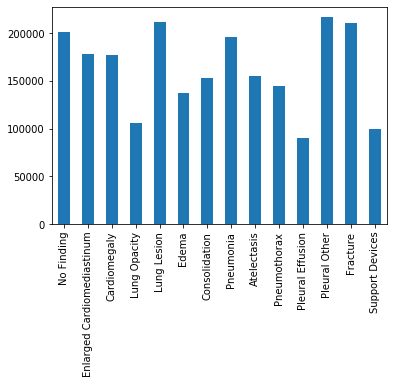

In [17]:
df_train.iloc[:,5:].isna().sum().plot.bar()

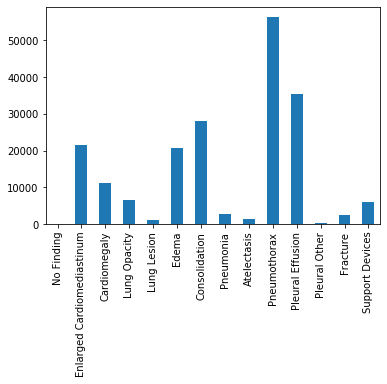

In [21]:
(df_train.iloc[:,5:]==0).sum().plot.bar()

In [27]:
df_train.iloc[:,5:].loc[:,['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
0,NaN,NaN,NaN,NaN,NaN
1,-1.0,-1.0,-1.0,-1.0,-1.0
2,NaN,NaN,-1.0,NaN,NaN
3,NaN,NaN,-1.0,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...
223409,-1.0,NaN,NaN,NaN,1.0
223410,-1.0,NaN,NaN,NaN,-1.0
223411,NaN,NaN,NaN,-1.0,NaN
223412,1.0,1.0,NaN,NaN,NaN


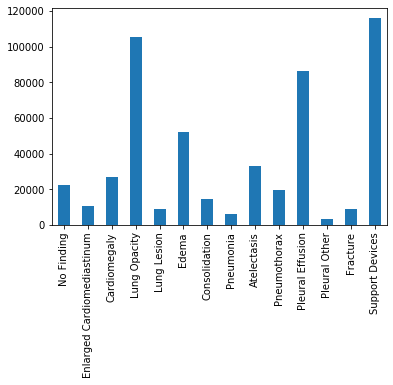

In [20]:
(df_train.iloc[:,5:]==1).sum().plot.bar()

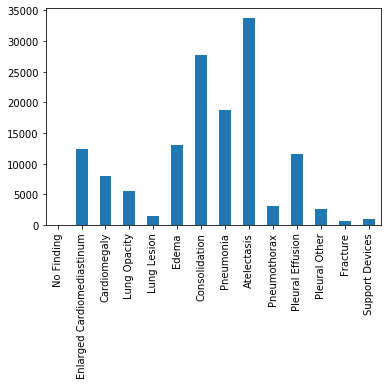

In [19]:
(df_train.iloc[:,5:]==-1).sum().plot.bar()

In [56]:
(~(df_train == -1).any(1)).sum(),(df_train == -1).any(1).sum()

(138358, 85056)

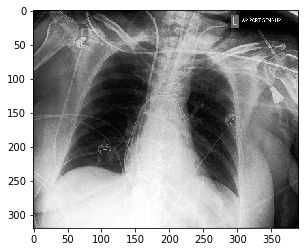

In [70]:
plt.imshow(plt.imread('data/'+df_train[((df_train == -1).sum(1) == 6)].iloc[1]['Path']),cmap='gray')

In [63]:
(df_train == -1).sum(1).value_counts()

0    138358
1     41919
2     33234
3      8283
4      1399
5       200
6        21
dtype: int64

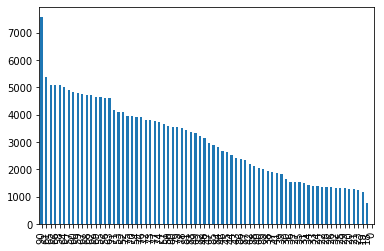

In [32]:
df_train['Age'].value_counts().plot.bar()

(array([138358.,  41919.,  33234.,   8283.,   1399.,    221.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 6 Patch objects>)

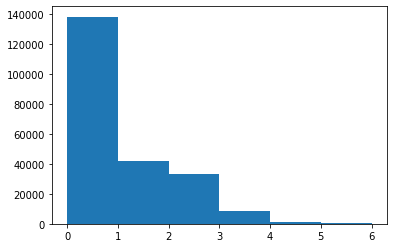

In [58]:
plt.hist((df_train == -1).sum(1),6)

In [150]:
((df_valid.iloc[:,5:] == 0).all(1).sum(), # all labels=0
(df_valid.iloc[:,5:-1] == 0).all(1).sum(), # labels != {Support devices} = 0
(df_valid.iloc[:,6:-1] == 0).all(1).sum()) # labels != {No Findings, Support devices} = 0

(9, 39, 77)

## Dataset/Loader

In [75]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [76]:
def advprop(image,**kwargs):
    return image*2.0-1.0
def get_transforms(varient='train', tfms_lib='albu', imgsize=(244,244)):
    if tfms_lib == 'albu':
        transform = A.Compose([
            A.RandomScale((-0.02,0.02)),
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0),A.CenterCrop(*imgsize, p=1.0)]),
                A.RandomCrop(*imgsize, p=1.0)
            ],p=1.0),
            A.CLAHE(p=0.5),
            A.HorizontalFlip(),
            A.Rotate((-7,7)),#,border_mode=cv2.BORDER_CONSTANT),
            A.IAAAffine(shear=(-5,5)),
            #A.Cutout(8,8,8),
            
            #A.Lambda(advprop),
            A.Normalize(),
            ToTensorV2(),
        ])
        
        tta_augments = A.Compose([
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0), A.CenterCrop(*imgsize,p=1.0)])
            ],p=1.0),
            A.OneOf([
                A.HorizontalFlip(),
                A.Rotate((-7,7)),#border_mode=cv2.BORDER_CONSTANT),
                A.IAAAffine(shear=(-5,5)),
                A.NoOp()
            ],p=1.0),
            A.Normalize(),
            ToTensorV2()
        ])
        
    elif tfms_lib == 'torch':
        transform = T.Compose([
            #T.RandomCrop(512,8,padding_mode='reflect') ,
            T.CenterCrop(imgsize),
            T.RandomHorizontalFlip(),
            T.RandomRotation(7),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            #T.RandomErasing(inplace=True)
        ])
        tta_augments = T.Compose([T.CenterCrop(32),T.ToTensor()])
        
    return transform if varient == 'train' else tta_augments

In [77]:
# (blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive)
class CheXDataset(Dataset):
    def __init__(self, df, use_albu=True, tfms=None, smooth_bounds=None, seed=None, dpath=PATH_DATA):
        
        self.df = df
        self.paths = self.df['Path'].values
        self.labels = self.df.iloc[:,1:].values.astype(float)
        #self.dpath = dpath
        self.tfms = tfms
        
        self.use_albu = use_albu
        self.smooth_bounds = smooth_bounds
        self._seedcntr=seed
        if self.tfms is not None:
            self.tfm_list = self.tfms.transforms.transforms if self.use_albu else self.tfms.transforms 
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        if self._seedcntr is not None:
            random.seed(self._seedcntr)
            self._seedcntr+=1
        labels = self.labels[idx]
        if self.smooth_bounds is not None:
            labels = np.where(labels==-1.,np.random.uniform(*self.smooth_bounds, size=len(labels)),labels)
        
        imgpath = str(PATH_DATA/self.paths[idx])
        
        is_lateral = 'lateral' in imgpath
        if self.use_albu:
            img = cv2.imread(imgpath)
            #img = template_match(img, template)
            #img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
            #img = np.expand_dims(cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE),2)
            aug = self.tfms(image=img, is_lateral=is_lateral)
            img = aug['image']
        else:
            img = Image.open(imgpath)
            img = self.tfms(img)
        
        return img,labels

In [335]:
# tmp_tfm = A.Rotate(7,border_mode=cv2.BORDER_CONSTANT)#A.Compose([A.RandomScale((-0.02,0.02),p=1),A.Resize(256,256),A.CenterCrop(244,244)], p=1)
# tmp_im = cv2.imread(str(PATH_DATA/df_train.Path.iloc[1]))
# tmp_tim = tmp_tfm(image=tmp_im)['image']
# print(tmp_im.shape,tmp_tim.shape)
# plt.imshow(tmp_tim)

In [123]:
def subset_dloader(df, grp_id=None, is_train=False, grp_name='ap_pa_ll', batch_size=32, seed=None, tfmlib='albu', print_tfms=True):
    if seed is not None:
        seed_everything(seed)
    
    set_tfms = get_transforms('train' if is_train else 'test', tfmlib, (244,244))
    
    df_subset = df[df[grp_name].eq(grp_id)] if grp_id is not None else df

    sub_dataset = CheXDataset(df=df_subset, use_albu=(tfmlib=='albu'), tfms=set_tfms, seed=seed)
    sub_loader = DataLoader(sub_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=is_train)
    
    if print_tfms:
        print(f'{"="*20} Augmentations {"="*20}','\n'.join([*map(str, sub_loader.dataset.tfm_list)]),'-'*55,sep='\n')
    
    return sub_loader

In [71]:
def get_dloaders(batch_size=32, sampsz=None, tfmlib='albu', seed=None, print_tfms=True, proc_kwargs=None):
    if seed is not None:
        seed_everything(seed)

    if proc_kwargs is None:
        proc_kwargs = dict(method='uones',smooth=True, nafill_val=0)
    
    df_trn = proc_df(df_train, **proc_kwargs)
    df_val = proc_df(df_valid)
    if sampsz is not None:
        df_trn = df_trn.sample(sampsz) #17->65k, 13->8k
    
    ualbu = (tfmlib=='albu')
    train_tfm = get_transforms('train', tfmlib, (244,244))
    valid_tfm = get_transforms('test', tfmlib, (244,244))

    train_dataset = CheXDataset(df=df_trn, use_albu=ualbu, tfms=train_tfm, seed=seed)#smooth_bounds=(0.55,0.8501)
    valid_dataset = CheXDataset(df=df_val, use_albu=ualbu, tfms=valid_tfm)

    train_loader = DataLoader(train_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=False)
    if print_tfms:
        print(f'{"="*20} Augmentations {"="*20}','\n'.join([*map(str, train_loader.dataset.tfm_list)]),'-'*55,sep='\n')
    
    return train_loader, valid_loader

In [ ]:
df_ptrain = proc_df(df_train,'uones',True,0)
df_ptrain[(df_ptrain[['Lung_Opacity','Consolidation']] == 1).all(1)][['Edema','Atelectasis','Pneumonia']]

In [85]:
df_pvalid = proc_df(df_valid)

In [124]:
val_loader = subset_dloader(df_pvalid, batch_size=1, print_tfms=False)

==================== Augmentations ====================
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
OneOf([
  HorizontalFlip(always_apply=False, p=0.5),
  Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None),
  IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect'),
  NoOp(always_apply=False, p=0.5),
], p=1.0)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0)
-------------------------------------------------------


In [125]:
model = CheXModel(use_sig=True)
#m2.classifier = lin
model =load_trained(model,'dn121_thawsteplr256bSig_223k_chkpnt.pt', save_path = '../save/models/') #.classifier = lin

In [127]:
for p in filter(lambda x: hasattr(x,'weight'), model.parameters()):
    p.requires_grad_(False)

In [128]:
@torch.no_grad()
def predict_loader(model, data_loader, sigmoid=True):
    was_training = model.training
    model.eval()
    preds = []
    for batch in tqdm(data_loader):
        data,target = to_device(batch, DEVICE)
        logits = model(data)
        pred = torch.sigmoid(logits) if sigmoid else logits
        preds.append(pred.detach())#.detach().to('cpu').numpy())
    model.train(was_training)
    return torch.vstack(preds).to('cpu').numpy()

In [ ]:
def validation_ensemble(model, df_pvalid, batch_size=32, n_ens=10):
    val_loader = subset_dloader(df_pvalid, is_train=False, batch_size=batch_size, print_tfms=False)
    preds = [predict_loader(model, val_loader, False)  for _ in range(n_ens)]
    pred_ens = np.mean(preds, 0)

In [138]:
val_loader1 = subset_dloader(df_pvalid, batch_size=1, print_tfms=False)
val_loader8 = subset_dloader(df_pvalid, batch_size=8, print_tfms=False)
val_loader32 = subset_dloader(df_pvalid, batch_size=32, print_tfms=False)
val_loader64 = subset_dloader(df_pvalid, batch_size=64, print_tfms=False)
val_loader256 = subset_dloader(df_pvalid, batch_size=256, print_tfms=False)

In [139]:
%time preds1x2 = [predict_loader(model, val_loader1, False)  for _ in range(2)] # preds1x2 = [preds1_ns,preds1_2ns]
%time preds8x2 = [predict_loader(model, val_loader8, False)  for _ in range(2)]
%time preds32x2 = [predict_loader(model, val_loader32, False)  for _ in range(2)]
%time preds64x2 = [predict_loader(model, val_loader64, False)  for _ in range(2)]
%time preds256x2 = [predict_loader(model, val_loader256, False) for _ in range(2)]


Wall time: 1min 8s



Wall time: 1min 5s



Wall time: 1min 5s



Wall time: 1min 7s


In [141]:
preds10x = [*preds1x2,*preds8x2,*preds32x2,*preds64x2,*preds256x2]

In [148]:
ensval_pred10x = np.mean(preds10x, 0)

In [334]:

ensval_pred10x

array([[0.3064258 , 0.08219822, 0.06226336, ..., 0.02242273, 0.15014651,
        0.16399738],
       [0.6702679 , 0.09251402, 0.01303238, ..., 0.01589196, 0.05971672,
        0.07422251],
       [0.5666095 , 0.10381728, 0.02600374, ..., 0.01664353, 0.06514832,
        0.42804998],
       ...,
       [0.16832873, 0.10942516, 0.25509614, ..., 0.01516676, 0.02927966,
        0.39672452],
       [0.56380004, 0.13439906, 0.4933238 , ..., 0.00722654, 0.03206138,
        0.20575753],
       [0.04727218, 0.14669107, 0.14370704, ..., 0.01889598, 0.03710177,
        0.5023645 ]], dtype=float32)

In [161]:
pred_df = val_loader.dataset.df.copy()

In [22]:
df_p1val = proc_df(df_valid)

In [171]:
pred_df.iloc[:,1:] = ensval_pred10x

In [174]:
roc_auc_score(df_p1val[TARGET_LABELS], pred_df[TARGET_LABELS], average='micro')

0.8708025539752609

In [175]:
pred_df.to_csv('../save/best_preds_08708.csv')

In [18]:
pred_df = pd.read_csv('../save/best_preds_08708.csv',index_col=0)

In [20]:
pred_df['patient_id'] = pred_df.Path.str.extract('patient(\d+)')

In [23]:
roc_auc_score(df_p1val.groupby('patient_id')[TARGET_LABELS].mean(), pred_df.groupby('patient_id')[TARGET_LABELS].mean(), average='micro')

KeyError: 'patient_id'

In [24]:
df_p1val['patient_id'] = df_p1val.Path.str.extract('patient(\d+)')

In [321]:
thsh = np.array([0.41811905, 0.04654205, 0.06883997, 0.27670593, 0.7215681 ,
       0.29367956, 0.10029919, 0.35940366, 0.1584397 , 0.19673136,
       0.39827909, 0.77037273, 0.77559368, 0.54789303])

In [327]:
allpos = (df_pxtrain[TARGET_LABELS] == 1).sum(0)

samptrn = subset_dloader(df_pxtrain[(df_xtrain != -1).all(1)].iloc[:,:-1].sample(250),print_tfms=False)

sampt_prd = predict_loader(model, samptrn, False)

In [318]:
roc_auc_score(samptrn.dataset.labels.round(),sampt_prd,average='micro',multi_class='ovo')

0.8786019975833219

In [319]:
roc_auc_score(samptrn.dataset.labels.round(),(sampt_prd>0.1337).astype(int),average='micro',multi_class='ovo')

0.7899876107006837

In [322]:
roc_auc_score(samptrn.dataset.labels.round(),(sampt_prd>thsh).astype(int),average='micro',multi_class='ovo')

0.7248627235044893

In [333]:
roc_auc_score(samptrn.dataset.labels.round(),(sampt_prd>(1-(allpos/allpos.sum()).values)).astype(int),average='micro',multi_class='ovo')

0.5716667431438229

In [ ]:
subset_dloader(df_xtrain)

In [25]:
df_p1val[TARGET_LABELS].values

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [28]:
y_true = df_p1val[TARGET_LABELS].values
y_pred = pred_df[TARGET_LABELS].values

In [339]:
TARGET5_LABELS

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']

In [341]:
{k:v for k,v in zip(TARGET5_LABELS,[roc_auc_score(y_true[:,i], ensval_pred10x[:,i], average='micro', multi_class='ovo') for i in TARGET5_IDX])}

{'Atelectasis': 0.8206168831168831,
 'Cardiomegaly': 0.7950921332388377,
 'Consolidation': 0.898236092265943,
 'Edema': 0.9193415637860082,
 'Pleural_Effusion': 0.931629278755921}

In [340]:
np.array([roc_auc_score(y_true[:,i], ensval_pred10x[:,i], average='micro', multi_class='ovo') for i in TARGET5_IDX]).mean().round(3)
    

0.873

In [187]:
roc_auc_score(y_true[:,TARGET5_IDX], (ensval_pred10x>=0.1337).astype(int), average='micro', multi_class='ovo')

0.7834741789294242

In [246]:
def tfunc(threshs):
    return roc_auc_score(y_true, (ensval_pred10xthreshs).astype(int), average='micro')

In [258]:
def linsearch_single(y_true, y_pred, num=1000, start=0,end=1):
    spac = np.linspace(start,end,num)
    tsco = [(t,roc_auc_score(y_true, (y_pred>=t).astype(int), average='micro', multi_class='ovo')) for t in spac]
    thrs,sco = max(tsco, key=lambda x: x[1])
    
    print(thrs, sco)
    return thrs

(0.28565565565565565, 0.7879967776584319)
(0.12477477477477476, 0.5460917431192661)
(0.08357357357357356, 0.73706591070163)
(0.32489489489489487, 0.83994708994709)
(0.017847847847847848, 0.5858369098712446)
(0.19148148148148147, 0.8518518518518519)
(0.11986986986986986, 0.8380823156942561)
(0.11986986986986986, 0.8019911504424779)
(0.31116116116116116, 0.7565746753246754)
(0.04727727727727728, 0.7201327433628318)
(0.3543243243243243, 0.847618196442935)
(0.03648648648648648, 0.927038626609442)
(0.27094094094094096, 0.815475752446832)


In [32]:
def rand_search(y_true, y_pred, low=0,  high=1, nsearch=1000):
    spac = np.random.uniform(low,high, (nsearch,14)) #np.random.rand(nsearch,14)
    best_auc = 0
    best = np.full(14, 0.5)
    for i in tqdm(range(nsearch)):
        sco = roc_auc_score(y_true, (y_pred>=spac[i]).astype(int), average='micro', multi_class='ovo')
        if sco > best_auc:
            print(f'AUC Improve: {sco:.5f} > {best_auc:.5f}')
            best_auc = sco
            best = spac[i]
            print('Thresh:',best.round(2))
            
    return best

In [47]:
def linsearch_obo(y_true, y_pred, start=0, end=1, num=1000):
    spac = np.linspace(start,end,num)
    threshsp = np.full(14,0.5)
    
    best_threshs = np.zeros(14)
    for i in tqdm(range(len(threshsp))):
        try:
            best_sco = 0
            for t in spac:
                sco = roc_auc_score(y_true[:,i], (y_pred[:,i]>=t).astype(int), average='micro')#, multi_class='ovo')
                if sco > best_sco:
                    best_sco = sco
                    best_threshs[i] = t
            print(i,best_sco)
        except ValueError:
            best_threshs[i] = 0.5
    
    #print(thrssco5)
    return best_threshs

In [92]:
from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve
from itertools import cycle

In [94]:
TARGET5_IDX

[8, 2, 6, 5, 10]

In [98]:
fprx,tprx,threshx = roc_curve(y_true[:, 8], y_pred[:, 8])

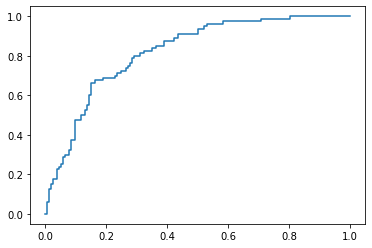

In [100]:
plt.plot(fprx,tprx,)

In [ ]:
TARGET5_IDX
fpr[i], tpr[i], threshx = roc_curve(y_true[:, i], y_pred[:, i])

In [133]:
def get_roc_dat(y_test, y_score, class_idx=None):
    # Compute ROC curve and ROC area for each class
    fpr,tpr,roc_auc = dict(),dict(),dict()
    n_classes = y_test.shape[1] if class_idx is None else len(class_idx)
    classrange = range(n_classes) if class_idx is None else class_idx
    for i in classrange:
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in classrange]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in classrange:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr,tpr,roc_auc

def plot_roc(y_test, y_score, class_idx=None, lw = 2):
    fpr, tpr, roc_auc = get_roc_dat(y_test, y_score,class_idx)
    # Plot all ROC curves
    fig,ax = plt.subplots(figsize=(8,6))
    
    ax.plot(fpr["micro"], tpr["micro"], label=f'micro-ROC ({roc_auc["micro"]:0.3f})',
             color='deeppink', linestyle=':', linewidth=4)

#     plt.plot(fpr["macro"], tpr["macro"],
#              label='macro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["macro"]),
#              color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    #for i, color in zip(range(n_classes), colors):
    for i in [*fpr.keys()][:-2]:
        ax.plot(fpr[i], tpr[i], lw=lw,label=f'{TARGET_LABELS[i]} ({roc_auc[i]:0.3f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('5 Pathologies ROC Curves')
    plt.legend()
    plt.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))

In [135]:
tprx5,fprx5, thsx5  = get_roc_dat(y_true, y_pred, TARGET5_IDX)

In [142]:
fpr8, tpr8, ths8 = roc_curve(y_true[:, 8], y_pred[:, 8])

In [225]:
ths8[Jstat(tpr8,fpr8).argmax()]

0.31629228591918945

In [222]:
def Jstat(tpr,fpr):
    '''https://en.wikipedia.org/wiki/Youden%27s_J_statistic'''
    return tpr + (1-fpr) - 1

In [240]:
def best_mthresh(y_true, y_pred, classidx=None):
    btx=[]
    clsrange = classidx if classidx is not None else range(y_true.shape[1])
    for i in clsrange:
        fpr, tpr, thsh = roc_curve(y_true[:, i], y_pred[:, i])
        bt = thsh[Jstat(tpr,fpr).argmax()]
        btx.append(bt)
        print(i,bt)
        
    btx = np.array(btx)
    if classidx is not None:    
        sco = roc_auc_score(y_true[:,classidx], y_pred[:,classidx] >= btx, average='micro',multi_class='ovr')
    else:
        sco = roc_auc_score(y_true, y_pred>=btx, average='micro',multi_class='ovr')
    
    print(sco)
    return btx

In [241]:
TARGET5_IDX

[8, 2, 6, 5, 10]

In [243]:
best_mthresh(y_true, y_pred)#, classidx=TARGET5_IDX)

0 0.29157742857933044
1 0.10779009759426117
2 0.08533476293087006
3 0.3314604759216309
4 0.01825455203652382
5 0.1920054852962494
6 0.1216307058930397
7 0.12185124307870865
8 0.31629228591918945
9 0.04811586812138557
10 0.3305885493755341
11 0.03701700270175934
12 1.6210619807243347
13 0.2715732455253601
0.7541588872684725


C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


array([0.29157743, 0.1077901 , 0.08533476, 0.33146048, 0.01825455,
       0.19200549, 0.12163071, 0.12185124, 0.31629229, 0.04811587,
       0.33058855, 0.037017  , 1.62106198, 0.27157325])

In [228]:
roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= btx)

0.8076334446024485

In [173]:
btx=[]
for i in range(14):
    fprx, tprx, thsx = roc_curve(y_true[:, i], y_pred[:, i])
    bt = thsx[np.sqrt(tprx * (1-fprx)).argmax()]
    btx.append(bt)
    print(i,bt)
btx = np.array(btx)

0 0.29157742857933044
1 0.10779009759426117
2 0.08591319620609282
3 0.3314604759216309
4 0.01825455203652382
5 0.1920054852962494
6 0.16249459981918335
7 0.12185124307870865
8 0.2277470380067825
9 0.04811586812138557
10 0.3305885493755341
11 0.03701700270175934
12 1.6210619807243347
13 0.2971423864364624


C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [185]:
btx2=[]
for i in range(14):
    fprx, tprx, thsx = roc_curve(y_true[:, i], y_pred[:, i], drop_intermediate=False)
    bt = thsx[(tprx-fprx).argmax()]
    btx2.append(bt)
    print(i,bt)
btx2 = np.array(btx2)

0 0.29157742857933044
1 0.10779009759426117
2 0.08533476293087006
3 0.3314604759216309
4 0.01825455203652382
5 0.1920054852962494
6 0.1216307058930397
7 0.12185124307870865
8 0.31629228591918945
9 0.04811586812138557
10 0.3305885493755341
11 0.03701700270175934
12 1.6210619807243347
13 0.2715732455253601


C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [186]:
np.mean((btx,btx2),0) == btx

array([ True,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False])

In [187]:
np.array(btx)

array([0.29157743, 0.1077901 , 0.0859132 , 0.33146048, 0.01825455,
       0.19200549, 0.1624946 , 0.12185124, 0.22774704, 0.04811587,
       0.33058855, 0.037017  , 1.62106198, 0.29714239])

In [188]:
roc_auc_score(y_true, (y_pred >= btx2).astype(int), average='micro', multi_class='ovr')

0.7541588872684725

In [182]:
btx2

array([0.29157743, 0.1077901 , 0.08533476, 0.33146048, 0.01825455,
       0.19200549, 0.12163071, 0.12185124, 0.31629229, 0.04811587,
       0.33058855, 0.037017  , 1.62106198, 0.27157325])

In [183]:
btfx = np.array([0.20068463, 0.02782656, 0.22480614, 0.0944551 , 0.68349336,
       0.29807413, 0.23258683, 0.59738751, 0.2830733 , 0.21930503,
       0.10788849, 0.29279912, 0.44835359, 0.29762549])

In [184]:
roc_auc_score(y_true, (y_pred >= btfx).astype(int), average='micro', multi_class='ovr')

0.8172021038665125

In [150]:
roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= btx)

0.8056560228691773

In [138]:
thsx5[8][np.sqrt(tprx5[8] * (1-fprx5[8])).argmax()]

IndexError: invalid index to scalar variable.

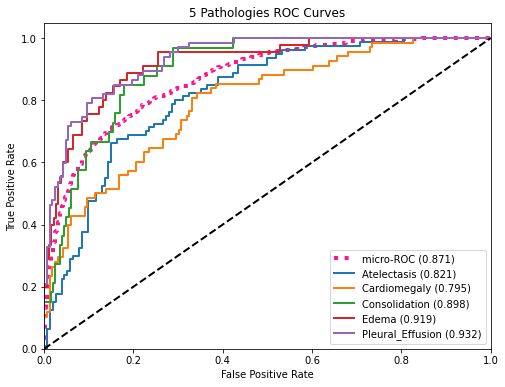

In [134]:
plot_roc(y_true,y_pred, TARGET5_IDX)

In [214]:
def optimal_thresh(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    if np.isnan(tpr).any():
        return 1
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return roc_t['threshold'].values[0]

In [215]:
roc_curve(y_true[:,12],y_pred[:,12])

C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(array([0.       , 0.0042735, 1.       ]),
 array([nan, nan, nan]),
 array([1.62106198, 0.62106198, 0.00219091]))

In [216]:
optthreshs = np.array([optimal_thresh(y_true[:,i],y_pred[:,i]) for i in range(14)])
optthreshs

array([0.29776311, 0.09289342, 0.10402228, 0.35648713, 0.01857257,
       0.2345043 , 0.16556875, 0.08833136, 0.24606614, 0.04811587,
       0.29342031, 0.037017  , 1.        , 0.34092045])

In [220]:
roc_auc_score(y_true, y_pred>=optthreshs, average='micro')#, multi_class='ovo')

0.7371084991616446

In [217]:
roc_auc_score(y_true[:,TARGET5_IDX], y_pred[:,TARGET5_IDX]>=optthreshs[TARGET5_IDX], average='micro', multi_class='ovo')

0.7870221551130326

In [48]:
best_lmthresh = linsearch_obo(y_true,y_pred, 0, 1, 5000)

0 0.7879967776584319
1 0.5548990825688074
2 0.7400779588944011
3 0.83994708994709
4 0.5901287553648069
5 0.8518518518518519
6 0.8405698778833107
7 0.8019911504424779
8 0.7565746753246754
9 0.722345132743363
10 0.8490928590580035
11 0.9291845493562232
13 0.815475752446832



In [52]:
best_lmthresh[-2] = 1

In [54]:
roc_auc_score(y_true, y_pred>=best_lmthresh, average='micro', multi_class='ovo')

0.7541588872684725

In [56]:
np.array([roc_auc_score(y_true[:,i], y_pred[:,i]>best_lmthresh[i], average='micro', multi_class='ovo') for i in TARGET5_IDX]).mean()

0.8076334446024485

In [50]:
np.array([roc_auc_score(y_true[:,i], y_pred[:,i]>best_lmthresh[i], average='micro', multi_class='ovo') for i in TARGET5_IDX])

array([0.75657468, 0.74007796, 0.84056988, 0.85185185, 0.84909286])

In [39]:
# [0.2  0.01 0.4  0.22 0.3  0.31 0.21 0.46 0.29 0.66 0.13 0.39 0.46 0.16]
best_mthresh = rand_search(y_true,y_pred, 0, 0.7, 5000)

AUC Improve: 0.68381 > 0.00000
Thresh: [0.09 0.16 0.33 0.23 0.55 0.4  0.6  0.05 0.49 0.55 0.13 0.27 0.25 0.43]
AUC Improve: 0.69005 > 0.68381
Thresh: [0.45 0.22 0.04 0.21 0.5  0.56 0.6  0.19 0.54 0.3  0.57 0.4  0.12 0.52]
AUC Improve: 0.80337 > 0.69005
Thresh: [0.67 0.02 0.24 0.35 0.29 0.14 0.19 0.16 0.06 0.4  0.55 0.64 0.62 0.24]
AUC Improve: 0.81192 > 0.80337
Thresh: [0.67 0.05 0.2  0.27 0.2  0.28 0.1  0.38 0.1  0.55 0.16 0.11 0.63 0.16]
AUC Improve: 0.81257 > 0.81192
Thresh: [0.57 0.01 0.1  0.19 0.48 0.35 0.26 0.31 0.   0.69 0.38 0.42 0.32 0.32]
AUC Improve: 0.81720 > 0.81257
Thresh: [0.2  0.03 0.22 0.09 0.68 0.3  0.23 0.6  0.28 0.22 0.11 0.29 0.45 0.3 ]



In [40]:
best_mthresh # 0.81720

array([0.20068463, 0.02782656, 0.22480614, 0.0944551 , 0.68349336,
       0.29807413, 0.23258683, 0.59738751, 0.2830733 , 0.21930503,
       0.10788849, 0.29279912, 0.44835359, 0.29762549])

In [44]:
threshbest5 = np.array([roc_auc_score(y_true[:,i], y_pred[:,i]>best_mthresh[i], average='micro', multi_class='ovo') for i in TARGET5_IDX])

In [45]:
threshbest5

array([0.74310065, 0.68311481, 0.7125735 , 0.81693122, 0.80690857])

In [46]:
threshbest5.mean()

0.7525257491090509

In [34]:
best_mthresh #  0.82537

array([0.60604859, 0.03938501, 0.01824971, 0.22275614, 0.22111713,
       0.26753655, 0.22301323, 0.21618334, 0.17627792, 0.66390855,
       0.26882524, 0.18634588, 0.26435561, 0.21400941])

In [261]:
threshs = np.array(tsco)[:,0]

In [267]:
threshs[-2]=1

In [176]:
for t in np.linspace(0.05,0.4,100):
    print(t,roc_auc_score(val_loader.dataset.labels, (ensval_pred10x>=t).astype(int), average='micro', multi_class='ovo'))

0.05 0.6976707991949547
0.05353535353535354 0.7075424006359745
0.05707070707070708 0.7165400969077418
0.06060606060606061 0.7250577331650091
0.06414141414141414 0.7317914496132929
0.06767676767676768 0.739291862492897
0.07121212121212121 0.7445212975896228
0.07474747474747476 0.7485470836704017
0.07828282828282829 0.7519925989581437
0.08181818181818182 0.7577521994586379
0.08535353535353536 0.7593636895481277
0.08888888888888889 0.759284472647776
0.09242424242424244 0.7611324937648182
0.09595959595959597 0.760809747877519
0.0994949494949495 0.7637682051913661
0.10303030303030303 0.7695278056918602
0.10656565656565657 0.7707454506265973
0.11010101010101012 0.77163335171464
0.11363636363636365 0.7736246910400926
0.11717171717171718 0.7771133137577083
0.12070707070707072 0.7798713495144816
0.12424242424242425 0.7791547584724294
0.12777777777777777 0.7796488144057192
0.13131313131313133 0.7805728249642404
0.13484848484848486 0.782850800706514
0.1383838383838384 0.7788530064633153
0.1419191

In [157]:
roc_auc_score(val_loader.dataset.labels, (ensval_pred10x>=0.5).astype(int), average='micro', multi_class='ovo')

0.6575710922694943

In [147]:
roc_auc_score(val_loader.dataset.labels, np.mean(preds10x, 0), average='micro', multi_class='ovo')

0.8708025539752609

In [143]:
[roc_auc_score(val_loader.dataset.labels, prd, average='micro', multi_class='ovo') for prd in preds10x]

[0.8673903489742392,
 0.8655059384683427,
 0.8678992405814463,
 0.871636150898398,
 0.8675465434279365,
 0.8688033769352856,
 0.8678555733148212,
 0.8675661377142425,
 0.8660831301592457,
 0.8688196122010823]

## Model

In [29]:
def recurse_children(mdl,max_depth=3,weighted_only=True,_depthidx=0):
    _depthidx+=1
    for n,c in mdl.named_children():
        wparam = [p for p in c.parameters()]
        nparam = len(wparam)
        trncnt = sum(p.requires_grad for p in wparam)
        if not weighted_only or any(hasattr(m,'weight') for m in c.modules()):
            print('  '*_depthidx,'-', n, f'({trncnt if trncnt>0 else "-"}/{nparam})')

        if _depthidx < max_depth:
            recurse_children(getattr(mdl,n),max_depth,weighted_only,_depthidx)

In [49]:
@torch.no_grad()
def compute_auc(out,target):
    targ = target.round().detach().to('cpu')
    out = torch.sigmoid(out).detach().to('cpu')
    score = roc_auc_score(targ, out, average='micro',multi_class='ovo')

    return score

@torch.no_grad()
def compute_auc_dbg(out,target,ninv=0):
    try:
        targ = target.round().detach().to('cpu')
        out = torch.sigmoid(out).detach().to('cpu')#out.detach().to('cpu')#F.softmax(out,0).detach().to('cpu')
        #score = roc_auc_score(targ, out, multi_class='ovo')
        score = roc_auc_score(targ, out, average='micro',multi_class='ovo')
    except ValueError as e:
        score = 0.5
        #print(targ[:5])
        #print(out[:5])
        #raise e
        ninv+=1
        #score = 0.5
    return score,ninv

In [31]:
def save_history(history, save_name, description, save_path='save/histories/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    desc = f'{save_name} - {description} \n'
    with full_path.joinpath('description.txt').open('a+') as f:
        f.write(desc)
    dump_path = full_path.joinpath(save_name).with_suffix('.pkl')    
    pickle.dump(history,dump_path.open('wb'))
    print('File saved to:',str(dump_path))

In [48]:
def save_trained(model, save_name, description=None, module='network', save_path='save/models/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    modelmod = getattr(model,module,model)
    states = OrderedDict(
        {n: c.state_dict() for n,c in modelmod.named_children() if any(p.requires_grad for p in c.parameters())}
    )
    if description is not None:
        desc = f"{save_name} - ({', '.join(states.keys())}) : {description} \n"
        with full_path.joinpath('description.txt').open('a+') as f:
            f.write(desc)
    
    out_path = full_path.joinpath(save_name).with_suffix('.pt')
    torch.save(states,out_path)
    
    print('state dict saved to:',out_path.as_posix())
    
def load_trained(model, save_name, module='network', save_path='save/models/'):
    """
    Example:
    model = CheXModel('densenet121')
    model = load_trained(model,'densenet121.pt')
    """
    load_path = Path(save_path).joinpath(save_name).with_suffix('.pt')
    saved_odict = torch.load(load_path)
    modelmod = getattr(model,module,model)
    
    for k,v in saved_odict.items():
        getattr(modelmod,k).load_state_dict(v)
        
    model.to(DEVICE)
    return model

## Train

In [33]:
class TrainerBase:
    def __init__(self):
        self.history = {}
    
    def freeze(self, param_names=None, invert_match=True, unfreeze=False):
        candidate_modules = [(n,m) for n,m in self.model.named_modules() if hasattr(m,'weight')]
        n_params = len(candidate_modules)

        child_names,children = zip(*[*self.model.named_children()])
        n_child = len(children)
        
        if param_names is None:
            child_train = [[x.requires_grad for x in child.parameters()] for child in self.model.children()]
            lay_df = pd.DataFrame({'Name':child_names,'Trainable': [f'{sum(c)}/{len(c)}' for c in child_train]})
            print(lay_df)

            print('Frozen Parameters: ({} / {})'.format((~init_trainables).sum(),n_params))
            print('Trainable Parameters: ({} / {})'.format(init_trainables.sum(),n_params))
            return
          
        for name,module in candidate_modules:
            if any(pn in name for pn in param_names): 
                if not invert_match:
                    module.requires_grad_(unfreeze)
            elif invert_match:
                module.requires_grad_(unfreeze)
               
        params_status = {'trainable':[],'frozen':[]}
        for n,m in candidate_modules:
            params_status['trainable' if any(p.requires_grad for p in m.parameters()) else 'frozen'].append(n)
    
        print(f'Trainable: {len(params_status["trainable"])}, Frozen: {len(params_status["frozen"])}')
        return params_status

        
    def update_history(self, **kwargs):
        for k,v in kwargs.items():
            self.history.setdefault(k,[]).append(v)
            
    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def save_improved(self, score, best_score, save_name=None, save_path='save/models'):
        if score > best_score:
            print(f'Score improved: {score:.5f} > {best_score:.5f}')
            best_score = score
            if save_name is not None:
                save_trained(self.model, save_name, save_path=save_path)
               
        return best_score
    
    def train_batch_end(self, i, log_freq, **kwargs):
        if log_freq is not None and i % log_freq==0:
            self.update_history(**kwargs)
    
    def train_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'train_loss':loss,'train_auc':auc})
    
    def validation_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'valid_loss':loss, 'valid_auc':auc}
    
    def epoch_end(self, epoch, exclude_keys=None):
        if exclude_keys is None:
            exclude_keys = ()
        hist_str = f'Epoch [{epoch}] '+', '.join([f'{k}: {v[-1]:.4f}' for k,v in self.history.items() if k not in exclude_keys])
        print(hist_str)

In [34]:
class Trainer(TrainerBase):
    def __init__(self, model, optimizer, criterion, scheduler=None, thaw_schedule=None, device=DEVICE):
        super(Trainer,self).__init__()
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.scheduler = scheduler
        self.thaw_schedule = thaw_schedule if thaw_schedule is not None else {}
    
    def train(self, train_loader, valid_loader, n_epochs=1, log_freq=None, save_name=None):
        best_val_auc = 0.0
        
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            train_loss, train_auc = self.train_one(train_loader, pbar, log_freq)
            self.train_epoch_end(train_loss=train_loss, train_auc=train_auc)
            
            valid_loss, valid_auc = self.evaluate(valid_loader, pbar)
            self.validation_epoch_end(valid_loss=valid_loss, valid_auc=valid_auc)
            
            best_val_auc = self.save_improved(valid_auc, best_val_auc, save_name=save_name)
            
            if self.scheduler is not None:
                if epoch in self.thaw_schedule:
                    self.freeze(self.thaw_schedule[epoch],invert_match=False,unfreeze=True)
                    
                self.scheduler.step()
                
            self.epoch_end(epoch, exclude_keys=['intraepoch_tloss','intraepoch_tauc'])
        
        return self.history
    
    
    def train_one(self, data_loader, pbar, log_freq=None):
        self.model.train()
        tloss,tauc=0,0
        nbat = len(data_loader)
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)

            loss.backward()
            self.optimizer.step()
                
            tloss+=loss.item()
            tauc+=compute_auc(output,target)
            
            itloss,itauc = tloss/(i+1),tauc/(i+1)
            pbar.set_postfix({'TLoss': f'{itloss:.4f}','TAUC': f'{itauc:.4f}'})
            self.train_batch_end(i,log_freq, intraepoch_tloss=itloss, intraepoch_tauc=itauc)
        
        return tloss/nbat, tauc/nbat
    
    @torch.no_grad()
    def evaluate(self, data_loader, pbar):
        self.model.eval()
    
        vlosses,vaucs=[],[]
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            output = self.model(data)
            loss = self.criterion(output, target)
            
            vlosses.append(loss.detach().item())
            vauc = compute_auc(output,target)
            vaucs.append(vauc)
            
            pbar.set_postfix({'VLoss': f'{np.mean(vlosses):.4f}', 'VAUC': f'{np.mean(vaucs):.4f}'})
        
        return np.mean(vlosses), np.mean(vaucs)

In [35]:
def make_trainer(arch='densenet121', lr=1e-3, scheduler=None, thaw_schedule=None):
    criterion = nn.BCEWithLogitsLoss()
    model = CheXModel(arch)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if scheduler=='steplr':
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1, verbose=True)
    trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schedule)
    pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)
    return trainer

## Experiments

In [51]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(32, None, seed=None)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'{arch}_thawsteplr_{nsamp}k'

thaw_schd = {1:('norm5','denseblock4'),2:('transition3','denseblock3'),
             3:('transition2','denseblock2'),4:('transition1','denseblock1')}

trainer = make_trainer(arch, 1e-3, 'steplr', thaw_schd)
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "steplr, grad thaw, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  RandomCrop(always_apply=False, p=1.0, height=244, width=244),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, me

Score improved: 0.81810 > 0.00000
state dict saved to: save/models/densenet121_thawsteplr_223k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3989, train_auc: 0.7916, valid_loss: 0.4012, valid_auc: 0.8181


Score improved: 0.82309 > 0.81810
state dict saved to: save/models/densenet121_thawsteplr_223k_chkpnt.pt
Trainable: 66, Frozen: 176
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [1] train_loss: 0.3870, train_auc: 0.8045, valid_loss: 0.4006, valid_auc: 0.8231


Score improved: 0.83688 > 0.82309
state dict saved to: save/models/densenet121_thawsteplr_223k_chkpnt.pt
Trainable: 164, Frozen: 78
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [2] train_loss: 0.3810, train_auc: 0.8122, valid_loss: 0.3841, valid_auc: 0.8369


Trainable: 214, Frozen: 28
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [3] train_loss: 0.3786, train_auc: 0.8167, valid_loss: 0.3799, valid_auc: 0.8352


KeyboardInterrupt: 

In [52]:
save_trained(trainer.model, 'dn121_thawsteplr_223k_ep4.pt', save_path='save/models')

state dict saved to: save/models/dn121_thawsteplr_223k_ep4.pt


In [56]:
save_desc = "steplr, grad thaw, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(trainer.history['valid_auc']))
save_history(trainer.history, 'dn121_thawsteplr_223k_ep4', save_desc)

File saved to: save/histories/dn121_thawsteplr_223k_ep4.pkl


==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=8, max_w_size=8)
Normalize(always_apply=False

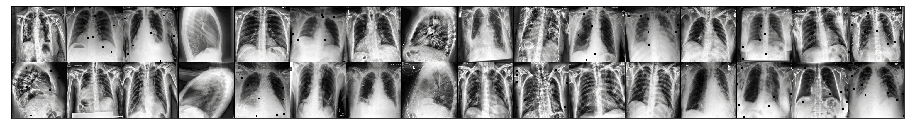

Adjusting learning rate of group 0 to 1.0000e-03.
Trainable: 2, Frozen: 362


Score improved: 0.82801 > 0.00000
state dict saved to: saves/models/densenet121_steplr_65k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3914, train_auc: 0.8013, valid_loss: 0.4056, valid_auc: 0.8280


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [1] train_loss: 0.3782, train_auc: 0.8176, valid_loss: 0.3968, valid_auc: 0.8264


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [2] train_loss: 0.3769, train_auc: 0.8191, valid_loss: 0.3961, valid_auc: 0.8222


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [3] train_loss: 0.3768, train_auc: 0.8193, valid_loss: 0.3958, valid_auc: 0.8238


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch [4] train_loss: 0.3768, train_auc: 0.8193, valid_loss: 0.3970, valid_auc: 0.8209

File saved to: save/histories/densenet121_steplr_65k.pkl
CPU times: user 40min 27s, sys: 10min 9s, total: 50min 36s
Wall time: 48min 46s


In [461]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(32, 2**16, seed=404)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'{arch}_steplr_{nsamp}k'

trainer = make_trainer(arch, 1e-3, train_loader, 'steplr')
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "steplr, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist,savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=8, max_w_size=8)
Normalize(always_apply=False

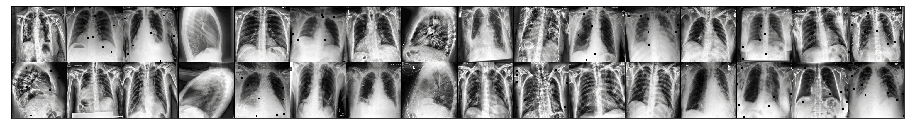

Trainable: 2, Frozen: 362


Score improved: 0.82897 > 0.00000
state dict saved to: saves/models/densenet121_131k_chkpnt.pt
Epoch [0] train_loss: 0.3885, train_auc: 0.8052, valid_loss: 0.3936, valid_auc: 0.8290


Score improved: 0.83033 > 0.82897
state dict saved to: saves/models/densenet121_131k_chkpnt.pt
Epoch [1] train_loss: 0.3838, train_auc: 0.8115, valid_loss: 0.3948, valid_auc: 0.8303


Epoch [2] train_loss: 0.3830, train_auc: 0.8126, valid_loss: 0.3920, valid_auc: 0.8294


Score improved: 0.83338 > 0.83033
state dict saved to: saves/models/densenet121_131k_chkpnt.pt
Epoch [3] train_loss: 0.3826, train_auc: 0.8132, valid_loss: 0.3908, valid_auc: 0.8334


Epoch [4] train_loss: 0.3822, train_auc: 0.8136, valid_loss: 0.3944, valid_auc: 0.8264

File saved to: save/histories/densenet121_131k.pkl
CPU times: user 1h 21min, sys: 20min 1s, total: 1h 41min 2s
Wall time: 1h 37min 16s


In [455]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(32, 2**17, seed=404)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
scheduler = optim.lr_scheduler.StepLR(opt, 1, gamma=0.1, verbose=True)
trainer = make_trainer(arch, 1e-3, train_loader)
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{arch}_{nsamp}k_chkpnt')

save_desc = "samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist,f'{arch}_{nsamp}k', save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=0, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

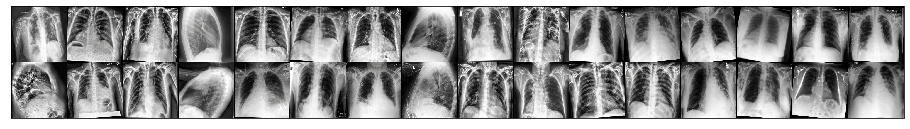

Trainable: 2, Frozen: 362


Score improved: 0.82639 > 0.00000
Epoch [0] train_loss: 0.3900, train_auc: 0.8030, valid_loss: 0.4032, valid_auc: 0.8264


Epoch [1] train_loss: 0.3828, train_auc: 0.8127, valid_loss: 0.4047, valid_auc: 0.8259


Epoch [2] train_loss: 0.3815, train_auc: 0.8145, valid_loss: 0.4006, valid_auc: 0.8257


Score improved: 0.82831 > 0.82639
Epoch [3] train_loss: 0.3808, train_auc: 0.8154, valid_loss: 0.3996, valid_auc: 0.8283


Epoch [4] train_loss: 0.3804, train_auc: 0.8160, valid_loss: 0.4077, valid_auc: 0.8190

File saved to: save/histories/densenet121_65k.pkl
state dict saved to: save/models/densenet121_65k.pt
CPU times: user 40min 46s, sys: 10min 4s, total: 50min 50s
Wall time: 48min 53s


In [338]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**16, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)

save_desc = f"samples 65k, batch 32, lr 1e-3, max val AUC, {max(hist['valid_auc']):0.5f}"
save_history(hist,'densenet121_65k', save_desc)
save_trained(model,'densenet121_65k',save_desc)

## Predict

In [220]:
@torch.no_grad()
def predict_one(model, img_tensor, label):
    was_training = model.training
    model.eval()
    logits = model(img_tensor.unsqueeze(0).to(DEVICE))
    pred = torch.sigmoid(logits.squeeze()).detach().to('cpu').numpy()
    #pred = F.softmax(logits.squeeze(),0).detach().to('cpu').numpy()

    label = label.to('cpu').numpy()
    show_timg(img_tensor, label, denorm=True)
    thresh_pred = (pred>0.5).astype(float)
    print(thresh_pred)
    print(pred.round(5))
    
    micro_auc = roc_auc_score(label, pred, average='micro', multi_class='ovo')
    macro_auc = roc_auc_score(label, pred, average='macro', multi_class='ovo')
    micro_auc_thresh = roc_auc_score(label, thresh_pred, average='micro', multi_class='ovo')
    macro_auc_thresh = roc_auc_score(label, thresh_pred, average='macro', multi_class='ovo')
    print(f'micro_auc: {micro_auc:.5f}, macro_auc: {macro_auc:.5f}')
    print(f'micro_auc_thresh: {micro_auc_thresh:.5f}, macro_auc_thresh: {macro_auc_thresh:.5f}')
    model.train(was_training)

    #return score

[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0.10153 0.08834 0.08984 0.60392 0.08338 0.40537 0.09958 0.0707  0.09884
 0.09219 0.58701 0.06834 0.08133 0.5497 ]
micro_auc: 0.72727, macro_auc: 0.72727
micro_auc_thresh: 0.57576, macro_auc_thresh: 0.57576


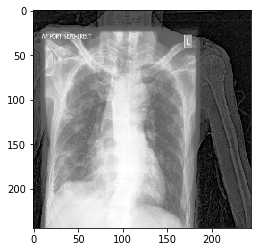

In [221]:
predict_one(trainer.model, v0[0][3], v0[1][3])

## Misc

In [ ]:
# AP -front back
# PA -back front

In [248]:
t0 = next(iter(train_loader))

In [ ]:
def auc_testing(dloader,model):
    for img_bat,label_bat in dloader:
        logits = model(img_bat.to(DEVICE))
        pp = torch.sigmoid(logits).detach().to('cpu')
        nplabs = label_bat#.round()
        print(pp.shape)
        print(pp)
        print(label_bat.shape)
        print(label_bat.round())
        print(label_bat.round().sum(1))
        sco = roc_auc_score(nplabs,pp,average='micro',multi_class='ovo')
        print(sco)
        break

In [335]:
tdft = df_train.copy() 
allempty_msk = (tdft.loc[:,'No Finding':].fillna(0) == 0.0).all(axis=1)
tdft.loc[allempty_msk,'No Finding'] = 1
#tdft.loc[allempty_msk,'No_Finding'] = 1

In [374]:
from sklearn.metrics import f1_score